In [99]:
import os
from dotenv import load_dotenv
import psycopg2
import datetime
load_dotenv()


POSTGRES_HOST= os.environ.get("POSTGRES_HOST")
POSTGRES_USERNAME= os.environ.get("POSTGRES_USERNAME")
POSTGRES_PASSWORD= os.environ.get("POSTGRES_PASSWORD")
POSTGRES_DATABASE_NAME= os.environ.get("POSTGRES_DATABASE_NAME")

conn = psycopg2.connect(
    host= POSTGRES_HOST,
    database= POSTGRES_DATABASE_NAME,
    user= POSTGRES_USERNAME,
    password= POSTGRES_PASSWORD
)


In [100]:
import findspark  
findspark.init()  
import pyspark # only run after findspark.init()  
from pyspark.sql import *  
from pyspark.conf import SparkConf  
from pyspark.context import SparkContext  
from pyspark.sql.types import LongType
import pandas as pd  
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import types
from pyspark.sql import functions as F

In [101]:
# https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

In [102]:
stock_price_schema = types.StructType([
    types.StructField("symbol", types.StringType(), True),
    types.StructField("date", types.DateType(), True),
    types.StructField("open", types.DoubleType(), True),
    types.StructField("high", types.DoubleType(), True),
    types.StructField("low", types.DoubleType(), True),
    types.StructField("close", types.DoubleType(), True),
    types.StructField("volume", types.IntegerType(), True),
    types.StructField("market_cap", types.LongType(), True),
    types.StructField("sma_50", types.DoubleType(), True),
    types.StructField("sma_200", types.DoubleType(), True),
    types.StructField("returns", types.DoubleType(), True)
])



In [114]:

def import_stock_from_postgres(conn, symbol):
    cursor = conn.cursor()
    cursor.execute("select * from stocks_historical where symbol = %s", (symbol,))
    data = cursor.fetchall()
    cursor.close()
    
    
    
    df = spark.createDataFrame(data=data,schema=stock_price_schema)
    
    if df.count() == 0:
        print(f"{symbol} is invalid")
        return
    
    
    if os.path.isdir(f"data/pq/{symbol}/"):
        df.repartition(4).write.mode("overwrite").parquet(f"data/pq/{symbol}/")
    else:
        df.repartition(4).write.parquet(f"data/pq/{symbol}/")
    
    print(f"Imported {symbol} successfully")

def retrieve_symbols(conn, table):
    cursor = conn.cursor()
    cursor.execute("select symbol from {}".format(table))
    data = pd.DataFrame(cursor.fetchall(), columns = ["symbol"])
    cursor.close()
    
    return data

In [115]:
symbols = retrieve_symbols(conn, "stocks_list")
symbols

,symbol
0,AAA
1,AAM
2,AAV
3,ABC
4,ABI
...,...
1322,YBM
1323,YEG
1324,YRC
1325,YTC


In [116]:
spark = SparkSession.builder.master("local[1]") \
                            .appName("import_data_from_postgres_to_spark") \
                            .getOrCreate()

In [117]:
mysymbol = "ABC"
import_stock_from_postgres(conn, mysymbol)

Imported ABC successfully


In [118]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [120]:
df = pd.read_parquet("data/pq/{}".format(mysymbol))
df = df.sort_values('date')

In [121]:
df

,symbol,date,open,high,low,close,volume,market_cap,sma_50,sma_200,returns
313,ABC,2017-01-11,37100.0,37100.0,37100.0,37100.0,3900,144690000,NaN,NaN,NaN
89,ABC,2017-02-06,35000.0,35000.0,35000.0,35000.0,3800,133000000,NaN,NaN,-0.056604
1046,ABC,2017-02-14,37000.0,37500.0,37000.0,37500.0,3000,111000000,NaN,NaN,0.071429
877,ABC,2017-02-15,37000.0,37000.0,37000.0,37000.0,7000,259000000,NaN,NaN,-0.013333
506,ABC,2017-02-20,37000.0,37000.0,37000.0,37000.0,100,3700000,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
498,ABC,2022-04-08,10000.0,10000.0,9300.0,9500.0,192535,1925350000,11328.0,12745.0,-0.120370
350,ABC,2022-04-15,9600.0,10000.0,9000.0,9100.0,103273,991420800,11292.0,12726.0,-0.042105
391,ABC,2022-04-22,8900.0,8900.0,8000.0,8100.0,105991,943319900,11230.0,12705.0,-0.109890
510,ABC,2022-04-29,8200.0,8600.0,7600.0,8200.0,42133,345490600,11156.0,12679.0,0.012346


In [122]:
training_set = df[df["date"] < datetime.date(2022, 1, 1)]["open"].values
training_set = training_set.reshape(len(training_set), -1)
training_set

array([[37100.],
       [35000.],
       [37000.],
       ...,
       [14400.],
       [14000.],
       [13400.]])

In [123]:
scaler = MinMaxScaler(feature_range=(0, 1))
sclaed_training_set = scaler.fit_transform(training_set)
sclaed_training_set

array([[0.61818182],
       [0.57575758],
       [0.61616162],
       ...,
       [0.15959596],
       [0.15151515],
       [0.13939394]])

In [124]:
X_train = []
Y_train = []

for i in range(60, len(sclaed_training_set)):
    X_train.append(sclaed_training_set[i-60:i, 0])
    Y_train.append(sclaed_training_set[i, 0])
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [125]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1115, 60, 1)

In [126]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [127]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences= True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [128]:
regressor.compile(optimizer= 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
35/35 [==============================] - 8s 63ms/step - loss: 0.0023
Epoch 2/100
35/35 [==============================] - 2s 59ms/step - loss: 0.0014
Epoch 3/100
35/35 [==============================] - 2s 59ms/step - loss: 9.6684e-04
Epoch 4/100
35/35 [==============================] - 2s 62ms/step - loss: 7.8902e-04
Epoch 5/100
35/35 [==============================] - 2s 60ms/step - loss: 8.0887e-04
Epoch 6/100
35/35 [==============================] - 2s 66ms/step - loss: 7.2500e-04
Epoch 7/100
35/35 [==============================] - 2s 70ms/step - loss: 7.8372e-04
Epoch 8/100
35/35 [==============================] - 2s 66ms/step - loss: 7.0241e-04
Epoch 9/100
35/35 [==============================] - 2s 62ms/step - loss: 6.8611e-04
Epoch 10/100
35/35 [==============================] - 2s 64ms/step - loss: 6.5870e-04
Epoch 11/100
35/35 [==============================] - 2s 67ms/step - loss: 6.2664e-04
Epoch 12/100
35/35 [==============================] - 2s 65ms/step - lo

In [129]:
testing_dataset = df["open"]
testing_dataset = testing_dataset[len(training_set) - 60:].values
testing_dataset = testing_dataset.reshape(len(testing_dataset), -1)
testing_dataset = scaler.transform(testing_dataset)

In [130]:
X_test = []
Y_test = []

for i in range(60, len(testing_dataset)):
    X_test.append(testing_dataset[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [131]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

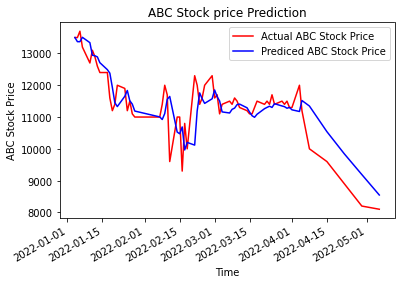

In [132]:
import matplotlib.pyplot as plt

actual_stock_price = df[df["date"] >= datetime.date(2022, 1, 1)]

plt.plot(actual_stock_price["date"].values, actual_stock_price["open"].values.reshape(len(actual_stock_price), -1), color = 'red', label = 'Actual {} Stock Price'.format(mysymbol))

plt.plot(actual_stock_price["date"].values, predicted_stock_price, color = 'blue', label = 'Prediced {} Stock Price'.format(mysymbol))
plt.title("{} Stock price Prediction".format(mysymbol))
plt.xlabel("Time")
plt.ylabel("{} Stock Price".format(mysymbol))
plt.gcf().autofmt_xdate()
plt.legend()